In [1]:
import os
import time
import json
import joblib
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
temp_data_1 = pd.read_excel('./data1/First_cut_ExampleData.xlsx')
temp_data_1.head()

,Day,Pattern,Variant,ApplicableDays,TrainType,Vervoerder,TrainCharacteristic,Trainnumber,Location,Past_Location,Activity,Ordernumber,PlannedTime,Track,BareDrivingTime,SlackPercentage,TractionType,TimetableSpeed
0,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Dv,NaN,V,1,2017-09-05 07:18:00,1,NaN,NaN,ICM7,140
1,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Twl,Dv,D,2,2017-09-05 07:21:00,2,227.0,NaN,ICM7,140
2,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Apdo,Twl,D,3,2017-09-05 07:25:00,2,194.0,NaN,ICM7,140
3,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Apda,Apdo,D,4,2017-09-05 07:26:00,DD,67.0,NaN,ICM7,140
4,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Apd,Apda,A,5,2017-09-05 07:28:00,1,73.0,"7,0",ICM7,140


In [3]:
temp_data_2 = pd.read_excel('./data1/Data_RAS/infra_overview.xlsx')
temp_data_2.head()

,FromLocation,FullNameFromLocation,ToLocation,FullNameToLocation,Hectometers,AverageAllowedSpeed,NumberOfParallelTracks,Diesel/Electric
0,Ac,Abcoude,Ashd,Amsterdam Holendrecht,23,120,4,E
1,Ac,Abcoude,Bkl,Breukelen,125,120,4,E
2,Adh,Achter de Hoven,Lw,Leeuwarden,20,100,1,D
3,Adh,Achter de Hoven,Lwc,Leeuwarden Camminghaburen,17,100,1,D
4,Ah,Arnhem,Ahp,Arnhem Velperpoort,13,100,2,E


## 距离表

In [4]:
locations_dis = pd.read_csv('./data1/Data_RAS/LocationDistances.csv')
locations_dis.head()

,from,to,distance
0,Ods,Dgrw,0.3
1,Dgrw,Asdma,1.9
2,Asdma,Asdm,0.9
3,Asdm,Asa,2.1
4,Asa,Dvd,2.9


In [5]:
locations = locations_dis.groupby(by=['from'])
len(locations)

472

## 时间表(可能用不到)

In [6]:
time_tables = pd.read_csv('./data1/Data_RAS/TimeTable.csv')
time_tables.head()

,Day,Trainnumber,Direction,Location,Abroad,Activity,Ordernumber,PlannedTime,TrainCharacteristic,Pattern,BareDrivingTime,TractionType,TimetableSpeed
0,4-9-2017,511,O,Zl,N,V,1.0,4-9-2017 05:44,IC,B500,NaN,ICM12,140.0
1,4-9-2017,511,O,Zlgea,N,D,2.0,4-9-2017 05:45,IC,B500,124.0,ICM12,140.0
2,4-9-2017,511,O,Hea,N,D,3.0,4-9-2017 05:47,IC,B500,123.0,ICM12,140.0
3,4-9-2017,511,O,Ddv,N,D,4.0,4-9-2017 05:52,IC,B500,287.0,ICM12,140.0
4,4-9-2017,511,O,Mp,N,K_A,5.0,4-9-2017 06:00,IC,B500,399.0,ICM12,140.0


## 测试数据集

In [7]:
datas = pd.read_csv('./data1/Data_RAS/ExampleTestSet_0800.csv')
datas.head()

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump
0,2017-11-07,500E,IC,512,Ut,V,2017-11-07 06:18:00,2017-11-07 06:18:16,0,0
1,2017-11-07,500E,IC,512,Utwa,D,2017-11-07 06:19:00,2017-11-07 06:20:26,1,1
2,2017-11-07,500E,IC,512,Utlr,D,2017-11-07 06:20:00,2017-11-07 06:21:55,1,0
3,2017-11-07,500E,IC,512,Utt,D,2017-11-07 06:21:00,2017-11-07 06:22:54,1,0
4,2017-11-07,500E,IC,512,Vtn,D,2017-11-07 06:22:00,2017-11-07 06:23:53,1,0


## 1. 数据预处理

### 1.1 读取数据

`The activity of this train. Where a V stands for a departure, a D stands for a passage, and an A stands for an arrival. A K can be added in front to indicate a short stop, which is an arrival and departure planned within the same minute.`

由于数据集较大，所以先采用测试数据集进行处理

In [8]:
final_datas = pd.read_csv('./data1/Data_RAS/RealisationData.csv')
final_datas = final_datas.drop(columns=['Cause'])

In [9]:
# 查看一下K_A和K_V的时间变换，发现较难处理，因此做简单处理
activities = datas.groupby(by=['Activity'])
for group, _ in activities:
    print(group)
#     if group == 'K_A' or group == 'K_V':
#         print(_)

A
D
K_A
K_V
V


### 1.2 取合理的延时时间范围

In [10]:
process_data = datas[(datas['Delay_min'] > -20) & (datas['Delay_min'] < 30)]
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump
0,2017-11-07,500E,IC,512,Ut,V,2017-11-07 06:18:00,2017-11-07 06:18:16,0,0
1,2017-11-07,500E,IC,512,Utwa,D,2017-11-07 06:19:00,2017-11-07 06:20:26,1,1
2,2017-11-07,500E,IC,512,Utlr,D,2017-11-07 06:20:00,2017-11-07 06:21:55,1,0
3,2017-11-07,500E,IC,512,Utt,D,2017-11-07 06:21:00,2017-11-07 06:22:54,1,0
4,2017-11-07,500E,IC,512,Vtn,D,2017-11-07 06:22:00,2017-11-07 06:23:53,1,0
...,...,...,...,...,...,...,...,...,...,...
14119,2017-11-07,810000O,LM,810515,Ns,D,2017-11-07 06:24:00,2017-11-07 06:23:42,0,0
14120,2017-11-07,810000O,LM,810515,Hde,D,2017-11-07 06:29:00,2017-11-07 06:27:54,-1,-1
14121,2017-11-07,810000O,LM,810515,Htba,D,2017-11-07 06:35:00,2017-11-07 06:34:11,0,1
14122,2017-11-07,810000O,LM,810515,Zlra,D,2017-11-07 06:36:00,2017-11-07 06:35:16,0,0


In [11]:
activities = process_data.groupby(by=['Delay_min'])
# for group, _ in activities:
#     print(group)

### 1.3 对时间进行转换为时间戳 (分两次使用，进行结果对比)

In [12]:
def todatetime(data):
    if isinstance(data, str):
        pass
    else:
        data = str(data)
    return int(time.mktime(time.strptime(data, '%Y-%m-%d %H:%M:%S')))

In [13]:
process_data['PlannedTime'] = process_data['PlannedTime'].apply(todatetime)

In [14]:
process_data['Realisation'] = process_data['Realisation'].apply(todatetime)
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump
0,2017-11-07,500E,IC,512,Ut,V,1510006680,1510006696,0,0
1,2017-11-07,500E,IC,512,Utwa,D,1510006740,1510006826,1,1
2,2017-11-07,500E,IC,512,Utlr,D,1510006800,1510006915,1,0
3,2017-11-07,500E,IC,512,Utt,D,1510006860,1510006974,1,0
4,2017-11-07,500E,IC,512,Vtn,D,1510006920,1510007033,1,0
...,...,...,...,...,...,...,...,...,...,...
14119,2017-11-07,810000O,LM,810515,Ns,D,1510007040,1510007022,0,0
14120,2017-11-07,810000O,LM,810515,Hde,D,1510007340,1510007274,-1,-1
14121,2017-11-07,810000O,LM,810515,Htba,D,1510007700,1510007651,0,1
14122,2017-11-07,810000O,LM,810515,Zlra,D,1510007760,1510007716,0,0


### 1.4 加入距离参数

In [15]:
# 得到一个对应关系，方便匹配，采用哈希存储，降低时间复杂度
locations_datas = locations_dis.values.tolist()
locations_json = {}
for locations_data in locations_datas:
    if locations_data[0] not in locations_json.keys():
        locations_json[locations_data[0]] = [[locations_data[1], locations_data[2]]]
    else:
        locations_json[locations_data[0]].append([locations_data[1], locations_data[2]])
# locations_json

In [16]:
with open('./locations.json', 'w') as f:
    json.dump(locations_json, f)

In [17]:
extract_numbers = process_data[['Trainnumber', 'Location']].values.tolist()

In [18]:
distances = []
got_number = []
departure = ''

for index, extract_number in enumerate(extract_numbers):
    if extract_number[0] not in got_number:
        got_number.append(extract_number[0])
        distance = 0
    else:
        distance = -1.
        try:
            dises = locations_json[extract_numbers[index-1][1]]
            for dis in dises:
                if dis[0] == extract_number[1]:
                    distance = dis[1]
                    break
        except:
            pass
    distances.append(distance)
process_data['distance'] = distances
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance
0,2017-11-07,500E,IC,512,Ut,V,1510006680,1510006696,0,0,0.0
1,2017-11-07,500E,IC,512,Utwa,D,1510006740,1510006826,1,1,1.4
2,2017-11-07,500E,IC,512,Utlr,D,1510006800,1510006915,1,0,1.9
3,2017-11-07,500E,IC,512,Utt,D,1510006860,1510006974,1,0,1.7
4,2017-11-07,500E,IC,512,Vtn,D,1510006920,1510007033,1,0,2.1
...,...,...,...,...,...,...,...,...,...,...,...
14119,2017-11-07,810000O,LM,810515,Ns,D,1510007040,1510007022,0,0,12.1
14120,2017-11-07,810000O,LM,810515,Hde,D,1510007340,1510007274,-1,-1,8.6
14121,2017-11-07,810000O,LM,810515,Htba,D,1510007700,1510007651,0,1,-1.0
14122,2017-11-07,810000O,LM,810515,Zlra,D,1510007760,1510007716,0,0,1.7


In [19]:
# 将没有距离的数据去掉
process_data = process_data[process_data['distance'] != -1]
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance
0,2017-11-07,500E,IC,512,Ut,V,1510006680,1510006696,0,0,0.0
1,2017-11-07,500E,IC,512,Utwa,D,1510006740,1510006826,1,1,1.4
2,2017-11-07,500E,IC,512,Utlr,D,1510006800,1510006915,1,0,1.9
3,2017-11-07,500E,IC,512,Utt,D,1510006860,1510006974,1,0,1.7
4,2017-11-07,500E,IC,512,Vtn,D,1510006920,1510007033,1,0,2.1
...,...,...,...,...,...,...,...,...,...,...,...
14117,2017-11-07,810000O,LM,810515,Nkk,D,1510006080,1510006121,0,0,5.3
14119,2017-11-07,810000O,LM,810515,Ns,D,1510007040,1510007022,0,0,12.1
14120,2017-11-07,810000O,LM,810515,Hde,D,1510007340,1510007274,-1,-1,8.6
14122,2017-11-07,810000O,LM,810515,Zlra,D,1510007760,1510007716,0,0,1.7


### 1.5 得出上一站的延迟时间

In [20]:
extract_minines = process_data[['Trainnumber', 'Delay_min']].values.tolist()
len(extract_minines)

12759

In [21]:
pre_delays = []
departure = ''

temp_number = extract_minines[0][0]
print(temp_number)
for index, extract_minine in enumerate(extract_minines):
    if temp_number != extract_minine[0]:
        # 能不用列表就少用，减少内存消耗
#         got_number.append(extract_number[0])
        temp_number = extract_minine[0]
        pre_delay = 0
    else:
        pre_delay = -1.
        try:
            pre_delay = extract_minines[index-1][1]
        except:
            pass
    pre_delays.append(pre_delay)
process_data['PreDelay_min'] = pre_delays
process_data['PreDelay_min'][0] = 0
process_data

512


,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min
0,2017-11-07,500E,IC,512,Ut,V,1510006680,1510006696,0,0,0.0,0
1,2017-11-07,500E,IC,512,Utwa,D,1510006740,1510006826,1,1,1.4,0
2,2017-11-07,500E,IC,512,Utlr,D,1510006800,1510006915,1,0,1.9,1
3,2017-11-07,500E,IC,512,Utt,D,1510006860,1510006974,1,0,1.7,1
4,2017-11-07,500E,IC,512,Vtn,D,1510006920,1510007033,1,0,2.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14117,2017-11-07,810000O,LM,810515,Nkk,D,1510006080,1510006121,0,0,5.3,0
14119,2017-11-07,810000O,LM,810515,Ns,D,1510007040,1510007022,0,0,12.1,0
14120,2017-11-07,810000O,LM,810515,Hde,D,1510007340,1510007274,-1,-1,8.6,0
14122,2017-11-07,810000O,LM,810515,Zlra,D,1510007760,1510007716,0,0,1.7,-1


### 1.6 将上一站计划时间与实际到达时间赋给下一站

In [22]:
extract_times = process_data[['Trainnumber', 'PlannedTime', 'Realisation']].values.tolist()

In [23]:
pre_plantimes = []
pre_realtimes = []

departure = ''

temp_number = extract_times[0][0]
print(temp_number)
for index, extract_time in enumerate(extract_times):
    # 如果是始发站，那么时间就赋予它原来的时间
    if temp_number != extract_minine[0]:
#         got_number.append(extract_number[0])
        temp_number = extract_minine[0]
        pre_plantime = extract_time[1]
        pre_realtime = extract_time[2]
    # 非始发站，时间赋予上一站的时间
    else:
        pre_plantime = extract_times[index-1][1]
        pre_realtime = extract_times[index-1][2]
    pre_plantimes.append(pre_plantime)
    pre_realtimes.append(pre_realtime)
    
process_data['Pre_plantimes'] = pre_plantimes
process_data['Pre_realtimes'] = pre_realtimes
process_data

512


,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min,Pre_plantimes,Pre_realtimes
0,2017-11-07,500E,IC,512,Ut,V,1510006680,1510006696,0,0,0.0,0,1510006680,1510006696
1,2017-11-07,500E,IC,512,Utwa,D,1510006740,1510006826,1,1,1.4,0,1510006680,1510006696
2,2017-11-07,500E,IC,512,Utlr,D,1510006800,1510006915,1,0,1.9,1,1510006740,1510006826
3,2017-11-07,500E,IC,512,Utt,D,1510006860,1510006974,1,0,1.7,1,1510006800,1510006915
4,2017-11-07,500E,IC,512,Vtn,D,1510006920,1510007033,1,0,2.1,1,1510006860,1510006974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14117,2017-11-07,810000O,LM,810515,Nkk,D,1510006080,1510006121,0,0,5.3,0,1510005960,1510005981
14119,2017-11-07,810000O,LM,810515,Ns,D,1510007040,1510007022,0,0,12.1,0,1510006080,1510006121
14120,2017-11-07,810000O,LM,810515,Hde,D,1510007340,1510007274,-1,-1,8.6,0,1510007040,1510007022
14122,2017-11-07,810000O,LM,810515,Zlra,D,1510007760,1510007716,0,0,1.7,-1,1510007340,1510007274


### 1.7 时间求差

In [24]:
process_data['residual'] = process_data['PlannedTime'] - process_data['Pre_realtimes']
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min,Pre_plantimes,Pre_realtimes,residual
0,2017-11-07,500E,IC,512,Ut,V,1510006680,1510006696,0,0,0.0,0,1510006680,1510006696,-16
1,2017-11-07,500E,IC,512,Utwa,D,1510006740,1510006826,1,1,1.4,0,1510006680,1510006696,44
2,2017-11-07,500E,IC,512,Utlr,D,1510006800,1510006915,1,0,1.9,1,1510006740,1510006826,-26
3,2017-11-07,500E,IC,512,Utt,D,1510006860,1510006974,1,0,1.7,1,1510006800,1510006915,-55
4,2017-11-07,500E,IC,512,Vtn,D,1510006920,1510007033,1,0,2.1,1,1510006860,1510006974,-54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14117,2017-11-07,810000O,LM,810515,Nkk,D,1510006080,1510006121,0,0,5.3,0,1510005960,1510005981,99
14119,2017-11-07,810000O,LM,810515,Ns,D,1510007040,1510007022,0,0,12.1,0,1510006080,1510006121,919
14120,2017-11-07,810000O,LM,810515,Hde,D,1510007340,1510007274,-1,-1,8.6,0,1510007040,1510007022,318
14122,2017-11-07,810000O,LM,810515,Zlra,D,1510007760,1510007716,0,0,1.7,-1,1510007340,1510007274,486


## 2. 制作标签建立训练集和测试集

- [pass!] 将延时时间小于等于0的置为1，其余置为0，归为二分类问题
- 做回归预测

In [25]:
# def get_label(data):
#     if data <= 0:
#         return 1
#     else:
#         return 0
    
# process_data['labels'] = process_data['Delay_min'].apply(get_label)
# process_data

### 2.1 对 `Activity` 这一列进行 `one-hot` 化

In [26]:
# 需要将状态转换成int型，因此对其one-hot化
df_activity = pd.get_dummies(process_data['Activity'])
process_data_final = pd.concat([process_data, df_activity], axis=1)
process_data_final

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min,Pre_plantimes,Pre_realtimes,residual,A,D,K_A,K_V,V
0,2017-11-07,500E,IC,512,Ut,V,1510006680,1510006696,0,0,0.0,0,1510006680,1510006696,-16,0,0,0,0,1
1,2017-11-07,500E,IC,512,Utwa,D,1510006740,1510006826,1,1,1.4,0,1510006680,1510006696,44,0,1,0,0,0
2,2017-11-07,500E,IC,512,Utlr,D,1510006800,1510006915,1,0,1.9,1,1510006740,1510006826,-26,0,1,0,0,0
3,2017-11-07,500E,IC,512,Utt,D,1510006860,1510006974,1,0,1.7,1,1510006800,1510006915,-55,0,1,0,0,0
4,2017-11-07,500E,IC,512,Vtn,D,1510006920,1510007033,1,0,2.1,1,1510006860,1510006974,-54,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14117,2017-11-07,810000O,LM,810515,Nkk,D,1510006080,1510006121,0,0,5.3,0,1510005960,1510005981,99,0,1,0,0,0
14119,2017-11-07,810000O,LM,810515,Ns,D,1510007040,1510007022,0,0,12.1,0,1510006080,1510006121,919,0,1,0,0,0
14120,2017-11-07,810000O,LM,810515,Hde,D,1510007340,1510007274,-1,-1,8.6,0,1510007040,1510007022,318,0,1,0,0,0
14122,2017-11-07,810000O,LM,810515,Zlra,D,1510007760,1510007716,0,0,1.7,-1,1510007340,1510007274,486,0,1,0,0,0


In [27]:
df_activity.columns

Index(['A', 'D', 'K_A', 'K_V', 'V'], dtype='object')

In [28]:
features = process_data_final[['A', 'D', 'K_A', 'K_V', 'V', 'distance', 'PreDelay_min']]
labels = process_data_final[['Delay_min']]

In [29]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12759 entries, 0 to 14123
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   A             12759 non-null  uint8  
 1   D             12759 non-null  uint8  
 2   K_A           12759 non-null  uint8  
 3   K_V           12759 non-null  uint8  
 4   V             12759 non-null  uint8  
 5   distance      12759 non-null  float64
 6   PreDelay_min  12759 non-null  int64  
dtypes: float64(1), int64(1), uint8(5)
memory usage: 1001.3 KB


In [30]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12759 entries, 0 to 14123
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Delay_min  12759 non-null  int64
dtypes: int64(1)
memory usage: 839.4 KB


### 2.2 分训练集和验证集



In [31]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.8, random_state=20)

### 2.3 标准化特征

对数据集进行标准化，不然MSE较大（在未标准化数据之前得到的MSE过百）

In [34]:
ss_X = StandardScaler()
# ss_y = StandardScaler()

X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

# y_train = ss_y.fit_transform(y_train)
# y_test = ss_y.transform(y_test)

## 3. 预测

In [35]:
def mse(x, y):
    return np.linalg.norm(x - y)

### 3.1 线性回归做Baseline

In [36]:
clf_linear = LinearRegression()
clf_linear.fit(X_train, y_train)
y_predict_linear = clf_linear.predict(X_test)

y_predict_linear = y_predict_linear.reshape(-1, 1)

In [37]:
mse_error_linear = mse(y_predict_linear, y_test)
print(f'The MSE Error is :{mse_error_linear:.4f}')

The MSE Error is :34.7082


In [38]:
print(f'R-squared value of linear regression is {clf_linear.score(X_test, y_test):.4f}')
print(f'The mean squared error of linear regression is {mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_linear)):.4f}')
print(f'The mean absoluate error of linear regression is {mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_linear)):.4f}')

R-squared value of linear regression is 0.8791
The mean squared error of linear regression is 0.9626
The mean absoluate error of linear regression is 0.4924


### 3.2 SVM预测

- 采用线性基

In [39]:
clf_svm_linear = SVR(C=1.2, kernel = "linear", gamma=0.01)
clf_svm_linear.fit(X_train, y_train)
y_predict_svm_linear = clf_svm_linear.predict(X_test)

y_predict_svm_linear = y_predict_svm_linear.reshape(-1, 1)

mse_error_svm_linear = mse(y_predict_svm_linear, y_test)
print(f'The MSE Error is :{mse_error_svm_linear:.4f}')

The MSE Error is :35.3496


In [40]:
print(f'R-squared value of linear SVR is {clf_svm_linear.score(X_test, y_test):.4f}')
print(f'The mean squared error of linear SVR is {mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_svm_linear)):.4f}')
print(f'The mean absoluate error of linear SVR is {mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_svm_linear)):.4f}')

R-squared value of linear SVR is 0.8746
The mean squared error of linear SVR is 0.9985
The mean absoluate error of linear SVR is 0.5846


- 采用径向基核函数

In [41]:
clf_svm_rbf = SVR(C=1.8, kernel = "rbf", gamma=0.001)
clf_svm_rbf.fit(X_train, y_train)
y_predict_svm_rbf = clf_svm_rbf.predict(X_test)

y_predict_svm_rbf = y_predict_svm_rbf.reshape(-1, 1)

mse_error_svm_rbf = mse(y_predict_svm_rbf, y_test)
print(f'The MSE Error is :{mse_error_svm_rbf:.4f}')

The MSE Error is :35.0362


In [42]:
print(f'R-squared value of rbf SVR is {clf_svm_rbf.score(X_test, y_test):.4f}')
print(f'The mean squared error of rbf SVR is {mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_svm_rbf)):.4f}')
print(f'The mean absoluate error of rbf SVR is {mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_svm_rbf)):.4f}')

R-squared value of rbf SVR is 0.8768
The mean squared error of rbf SVR is 0.9808
The mean absoluate error of rbf SVR is 0.5491


## 4. 加入时间变量做预测

### 4.1 分离特征和标签，特征中加入时间变量

由于当前时间变量是未知的，所以只能取上一车次的时间变量，类似于距离，同样增加新的两列参数，求得这一列车与上一列到达时间的残差，并将计划时间与残差均放入特征中

In [46]:
features = process_data_final[['A', 'D', 'K_A', 'K_V', 'V', 'distance', 'PreDelay_min', 'residual', 'PlannedTime']]
labels = process_data_final[['Delay_min']]

### 4.2 分数据集

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=20)
residual_test = X_test[['residual']]

### 4.3 标准化

In [50]:
ss_X = StandardScaler()
ss_y = StandardScaler()

X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

y_train = ss_y.fit_transform(y_train)
y_test = ss_y.transform(y_test)

### 4.4 预测

In [51]:
clf = SVR(C=1.5, kernel = "linear", gamma=0.01)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

y_predict = y_predict.reshape(-1, 1)

mse_error = mse(y_predict, y_test)
print(f'The MSE Error is :{mse_error}')

print(f'R-squared value of linear SVR is {clf.score(X_test, y_test):.4f}')
print(f'The mean squared error of linear SVR is {mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict)):.4f}')
print(f'The mean absoluate error of linear SVR is {mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict)):.4f}')

The MSE Error is :18.36139474021756
R-squared value of linear SVR is 0.8614
The mean squared error of linear SVR is 1.0671
The mean absoluate error of linear SVR is 0.5525


### 4.5 保存模型

In [52]:
model_path = './models/'
joblib.dump(clf, model_path + 'exp1_model.pkl')

['./models/exp1_model.pkl']

## 5. 可视化结果

### 5.1 将残差作为横坐标，预测结果和真实结果分为不同颜色显示

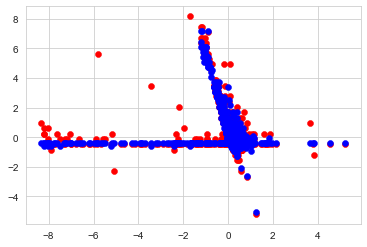

In [226]:
plt.scatter(residual_test, y_test,color='red', linewidth=0.5)
plt.scatter(residual_test, y_predict,color='blue', linewidth=0.5, ls='-')

In [219]:
residual_sta = ss_X.fit_transform(process_data_final[['residual']]).reshape(len(residual_sta))
plantime_sta = ss_X.fit_transform(process_data_final[['PlannedTime']]).reshape(len(plantime_sta))
residual_sta.shape

(12759,)

### 5.3 画出回归图，简单理解就是不同颜色为不同的类

In [223]:
sta_df = pd.DataFrame([residual_sta, plantime_sta]).T
sta_df.columns = ['residual', 'PlannedTime']
sta_df['Delay_min'] = process_data_final['Delay_min']
sta_df

,residual,PlannedTime,Delay_min
0,0.095958,-1.320255,0.0
1,0.162092,-1.290383,1.0
2,0.084936,-1.260511,1.0
3,0.052971,-1.230639,1.0
4,0.054073,-1.200767,1.0
...,...,...,...
12754,0.222714,-1.618973,2.0
12755,1.126543,-1.141024,2.0
12756,0.464103,-0.991664,2.0
12757,0.649277,-0.782561,2.0


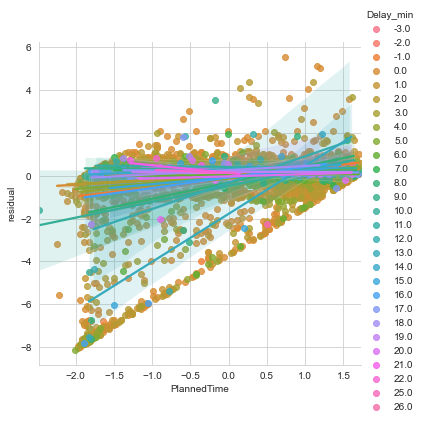

In [225]:
sns.lmplot(x="PlannedTime", y="residual", data=sta_df, hue='Delay_min', size=5,order=1)